# Table of Contents
 <p><div class="lev1"><a href="#Derive-scaling"><span class="toc-item-num">1&nbsp;&nbsp;</span>Derive scaling</a></div><div class="lev2"><a href="#Compute-statistics"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compute statistics</a></div><div class="lev3"><a href="#Decompose-bias-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Decompose bias into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev2"><a href="#Decompose-the-variance"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Decompose the variance</a></div><div class="lev3"><a href="#Decompose-Variance-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Decompose Variance into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev3"><a href="#Decompose-variance-into-its-contributions-from-T-and-omega-(ignore-variability-in-pressure)"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Decompose variance into its contributions from T and omega (ignore variability in pressure)</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [143]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])
print()
## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *

-- loading modules

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'physicalConstants', 'plot1DInvLog', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']



In [71]:
print("-- define global variables")
print()

print("- choosing options:")
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
time_stride = 'day'
resolution = 'dx'
daskarray = True
dates = ('185005010000','185005020000')

for v in ['compset','experiment','member','subset','time_stride','resolution',\
          'daskarray','dates']:
    print("%s:"%v,getattr(thismodule,v))

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(figdir,exist_ok=True)    

## Define percentile values
Q_IL_ext = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987])
Q_IL_ext_colorbar = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987,99.999])
Qs = [90.,96.8377,99.,99.6838,99.9,99.9684,99.99,99.9968]
Q_ids = ['90.0','96.8377','99.0','99.6838','99.9','99.9684','99.99','99.9968']

print()

-- define global variables

- choosing options:
compset: FSPCAMm_AMIP
experiment: piControl
member: r1i1p1
subset: tropics
time_stride: day
resolution: dx
daskarray: True
dates: ('185005010000', '185005020000')



In [4]:
print("-- load environment and variables")
print()

historyFilesSettings = getCAMHistoryFilesSettings()

inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

q_id = 'Q'
spechum = getValues(q_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
ts_id = 'TS'
ts = getValues(ts_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
ta_id = 'T'
ta = getValues(ta_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
relhum_id = 'RELHUM'
relhum = getValues(relhum_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)


-- load environment

Importing Q from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing OMEGA from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing PRECT from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing TS from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing T from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing RELHUM from 24 history files between 1850-05-01-00000 and 1850-05-01-82800



In [5]:
## Get longitude, latitude and landmask

print("- load geographic data")

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)
lon2D = da.from_array(lon2D,chunks=lon2D.shape)
lat2D = da.from_array(lat2D,chunks=lat2D.shape)

landmask = fh.variables['landmask']



-- load geographic data



In [6]:
print("- load surface pressure")

input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
pres = computeP(ps)
cn = getArrayType(pres)


-- load surface pressure
Importing PS from 24 history files between 1850-05-01-00000 and 1850-05-01-82800



# Derive scaling

In [7]:
print("-- compute (percentile-wise and pointwise) scaling approximation")
print()

-- compute (percentile-wise and pointwise) scaling approximation



In [8]:
%%time
print("compute 2D surfaces of predictor variables")
p_500 = 50000; levdim=1
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables

CPU times: user 866 ms, sys: 348 ms, total: 1.21 s
Wall time: 797 ms


In [119]:
def adjustRanks(Y,Yranks,ranks_ref):
    
    """Assuming that all Yranks are in ranks_ref."""

    Y_adj = np.array([np.nan]*ranks_ref.size)
    for iQ in range(Yranks.size):
        iQ_ref = indexOfRank(Yranks[iQ],ranks_ref)
        Y_adj[iQ_ref] = Y[iQ]
    
    return Y_adj

In [125]:
%%time
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)

targetranks = ranks[8:]
ranks_ref = Q_IL
percentiles = adjustRanks(centers,ranks,ranks_ref)

rank_locations= {}
for rank in Q_IL:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 
CPU times: user 89.1 ms, sys: 12.1 ms, total: 101 ms
Wall time: 94.8 ms


In [126]:
print("compute sample size in each bin")
N_prQ = sampleSizeAtAllRanks(targetranks,pr,ranks_ref,rank_locations=rank_locations)
print(np.nansum(N_prQ),pr.size)

compute sample size in each bin
2934.0 18432


In [127]:
%%time

print("compute pointwise scaling")
eps, pr_sc_vQ = computeScalingOmegaQAtAllRanks(targetranks,omega_500,qvstar_s,pr,ranks_ref=ranks_ref[iQ_slice],
                                                  bins=bins,rank_locations=rank_locations)
pr_sc_vQ = adjustRanks(pr_sc_vQ,targetranks,ranks_ref)
pr_sc = singleLevelScalingFromOmegaQ(omega_500,qvstar_s,efficiency=eps)
print("eps =",eps)

compute pointwise scaling
eps = 0.000534980294616
CPU times: user 12.7 s, sys: 2.57 s, total: 15.3 s
Wall time: 13.1 s


## Compute statistics

In [14]:
print()
print("-- compute statistics")
print()

-- compute statistics



In [128]:
%%time
print("mean of scaling in pr bins")
pr_sc_prQ = meanXAtAllYRanks(targetranks,pr_sc,pr,ranks_ref,rank_locations=rank_locations)

mean of scaling in pr bins
CPU times: user 6.54 s, sys: 1.37 s, total: 7.91 s
Wall time: 6.82 s


In [129]:
%%time
print("interquartile and 90% ranges")
ranks_I90 = (5,95)
ranks_IQR = (25,75)

pr_sc_I90 = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_sc_IQR = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)


interquartile and 90% ranges
CPU times: user 5.43 s, sys: 1.25 s, total: 6.68 s
Wall time: 5.59 s


> plot PDF with scaling and variability


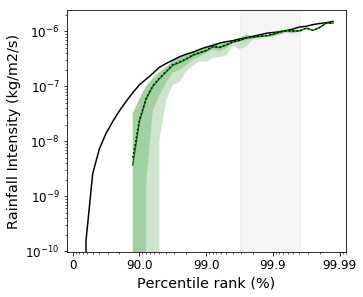

In [130]:
print("> plot PDF with scaling and variability")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)
# 90% confidence interval for pointwise scaling 2
subplotYShadingRanksILog(ax,ranks_ref,[pr_sc_I90[:,0],pr_sc_IQR[:,1]],col='green',transformX=False)
# Interquartile range for pointwise scaling 2
subplotYShadingRanksILog(ax,ranks_ref,[pr_sc_IQR[:,0],pr_sc_IQR[:,1]],col='green',transformX=False)
# Mean of pointwise scaling 2
subplotRanksILog(ax,ranks_ref,[percentiles,pr_sc_prQ,pr_sc_vQ],col=['k','green','k'],ltype=['-','-',':'],transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Rainfall Intensity (kg/m2/s)')
# ax.set_title(r'$\varepsilon\omega_{500}q_v^\star(T)$')

plt.savefig(os.path.join(figdir,'pdf_P_and_Psc_mean_IQR_I90_%s.pdf'%('-'.join(dates))),
            bbox_inches='tight')

plt.show()

### Decompose bias into its contributions from qvstar and omega (scaling #3)

In [21]:
print()
print("-- decompose bias into qvstar and omega contributions")
print()

-- decompose bias into qvstar and omega contributions



In [132]:
%%time
print("Q-mean terms")
qvstar_s_prQ = meanXAtAllYRanks(targetranks,qvstar_s,pr,ranks_ref,rank_locations=rank_locations)
omega_500_prQ = meanXAtAllYRanks(targetranks,omega_500,pr,ranks_ref,rank_locations=rank_locations)

Q-mean terms
CPU times: user 8.9 s, sys: 1.9 s, total: 10.8 s
Wall time: 9.12 s


In [133]:
%%time
print("Compute bias")
bias_sc = (pr_sc_prQ - pr_sc_vQ)/pr_sc_prQ
print(np.nanmean(bias_sc[iQ_slice]))

Compute bias
-0.00708678624255
CPU times: user 615 µs, sys: 502 µs, total: 1.12 ms
Wall time: 630 µs


In [134]:
%%time
print("covariance term")
cov_qvstar_s_omega_500_prQ = covAtAllYRanks(targetranks,qvstar_s,omega_500,pr,ranks_ref,
                                            rank_locations=rank_locations)

covariance term
CPU times: user 3.62 s, sys: 765 ms, total: 4.38 s
Wall time: 3.79 s


In [135]:
print("normalized contribution")
contrib_b_cov_qvstar_s_omega_500 = cov_qvstar_s_omega_500_prQ*(-eps/gg)/pr_sc_prQ

normalized contribution


> plot bias and corresponding contributions


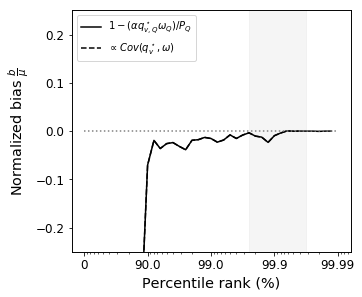

CPU times: user 1.01 s, sys: 25.3 ms, total: 1.03 s
Wall time: 1.04 s


In [144]:
%%time
print("> plot bias and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.25,.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 bias_sc,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 contrib_b_cov_qvstar_s_omega_500,
                 col='k',ltype='--',transformX=True)

ax.legend([r'$1-(\alpha q_{v,Q}^\star \omega_Q) / P_Q$',r'$\propto Cov(q_v^\star,\omega)$'])

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Normalized bias $\frac{b}{\mu}$')

plt.savefig(os.path.join(figdir,'bias_and_cov_omega_q_%s.pdf'%('-'.join(dates))),
            bbox_inches='tight')

plt.show()

## Decompose the variance

### Decompose Variance into its contributions from qvstar and omega (scaling #3)

In [31]:
print()
print("-- decompose variance into qvstar and omega contributions")
print()

-- decompose variance into qvstar and omega contributions


In [145]:
%%time 
print("Compute the variance in pr")
var_pr_sc_prQ = varXAtAllYRanks(targetranks,pr_sc,pr,ranks_ref,rank_locations=rank_locations)

Compute the variance in pr
CPU times: user 6.07 s, sys: 1.34 s, total: 7.41 s
Wall time: 6.27 s


In [146]:
print("normalized variability")
norm_var_pr_sc_prQ = var_pr_sc_prQ/(pr_sc_prQ**2)
print(np.nanmean(norm_var_pr_sc_prQ[iQ_slice]))

normalized variability
0.0115176171345


In [147]:
%%time
print("compute variability terms")
var_qvstar_s_prQ = varXAtAllYRanks(targetranks,qvstar_s,pr,ranks_ref,rank_locations=rank_locations)
var_omega_500_prQ = varXAtAllYRanks(targetranks,omega_500,pr,ranks_ref,rank_locations=rank_locations)
cov_qvstar_s_omega_500_prQ = covAtAllYRanks(targetranks,qvstar_s,omega_500,pr,ranks_ref,
                                            rank_locations=rank_locations)
cov_qvstar_s_2_omega_500_2_prQ = covAtAllYRanks(targetranks,qvstar_s**2,omega_500**2,pr,ranks_ref,
                                                rank_locations=rank_locations)

compute variability terms
CPU times: user 15.2 s, sys: 3.27 s, total: 18.5 s
Wall time: 15.7 s


In [163]:
print("normalized contributions, expanded terms")

# a_v = (eps/gg)**2
# contrib_covX2Y2 = a_v*cov_qvstar_s_2_omega_500_2_prQ/(pr_sc_prQ**2)
# contrib_varX = a_v*(omega_500_prQ**2)*var_qvstar_s_prQ/(pr_sc_prQ**2)
# contrib_varY = a_v*(qvstar_s_prQ**2)*var_omega_500_prQ/(pr_sc_prQ**2)
# contrib_varXvarY = a_v*var_qvstar_s_prQ*var_omega_500_prQ/(pr_sc_prQ**2)
# contrib_cov2XY = -a_v*(cov_qvstar_s_omega_500_prQ**2)/(pr_sc_prQ**2)
# contrib_covXY = -a_v*2*qvstar_s_prQ*omega_500_prQ*cov_qvstar_s_omega_500_prQ/(pr_sc_prQ**2)
contrib_covX2Y2 = cov_qvstar_s_2_omega_500_2_prQ/((omega_500_prQ*qvstar_s_prQ)**2)
contrib_varX = var_qvstar_s_prQ/(qvstar_s_prQ**2)
contrib_varY = var_omega_500_prQ/(omega_500_prQ**2)
contrib_varXvarY = var_qvstar_s_prQ*var_omega_500_prQ/((omega_500_prQ*qvstar_s_prQ)**2)
contrib_cov2XY = -(cov_qvstar_s_omega_500_prQ**2)/((omega_500_prQ*qvstar_s_prQ)**2)
contrib_covXY = -2*cov_qvstar_s_omega_500_prQ/(omega_500_prQ*qvstar_s_prQ)
contrib_sum = contrib_covX2Y2 + contrib_varX + contrib_varY + contrib_varXvarY + contrib_cov2XY + contrib_covXY

print(np.nanmean(contrib_varX[iQ_slice]),np.nanmean(contrib_varY[iQ_slice]),
      np.nanmean(contrib_varXvarY[iQ_slice]),
      np.nanmean(contrib_cov2XY[iQ_slice]),np.nanmean(contrib_covXY[iQ_slice]),
      np.nanmean(contrib_sum[iQ_slice]))

normalized contributions, expanded terms
0.00851937934551 0.0170785921814 0.00018750980497 -9.57057702885e-05 0.0139788453359 0.0114033255882


> plot variance and corresponding contributions


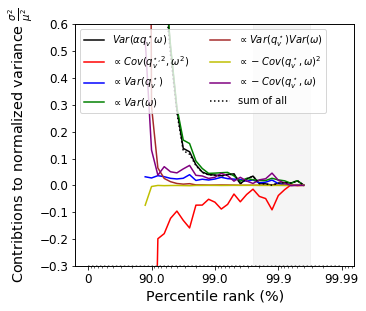

CPU times: user 1.74 s, sys: 49 ms, total: 1.79 s
Wall time: 1.89 s


In [164]:
%%time
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)
subplotRanksILog(ax,ranks_ref,
                 [contrib_covX2Y2,contrib_varX,contrib_varY,contrib_varXvarY,contrib_cov2XY,contrib_covXY,contrib_sum],
                 col=['r','b','g','brown','y','purple','k'],ltype=['-','-','-','-','-','-',':'],transformX=True)

# subplotXShadingRanksILog(ax,ranks,(0,10),alpha=1,col='white',transformX=True)

leg = ax.legend([r'$Var(\alpha q_v^\star \omega)$',
                 r'$\propto Cov(q_v^{\star,2},\omega^2)$',
                 r'$\propto Var(q_v^\star)$',
                 r'$\propto Var(\omega)$',
                 r'$\propto Var(q_v^\star)Var(\omega)$',
                 r'$\propto -Cov(q_v^\star,\omega)^2$',
                 r'$\propto -Cov(q_v^\star,\omega)$',
                 r'sum of all'],
                 loc='upper left',
                 framealpha=0.8,
                 ncol=2)

# ax2 = ax.twinx()
# ax2.set_yscale('log')
# subplotRanksILog(ax2,ranks,
#                  N_prQ,
#                  col='gray',ltype='-',transformX=False)
# ax2.tick_params(axis='y', colors='gray')

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contribtions to normalized variance $\frac{\sigma^2}{\mu^2}$')

plt.savefig(os.path.join(figdir,'var_and_contributions_omega_q_%s.pdf'%('-'.join(dates))),
            bbox_inches='tight')

plt.show()

### Decompose variance into its contributions from T and omega (ignore variability in pressure)

In [38]:
print()
print("-- decompose variance into T and omega contributions")
print()

-- decompose variance into T and omega contributions


In [165]:
print("Q-mean terms")
ts_prQ = meanXAtAllYRanks(targetranks,ts,pr,ranks_ref,rank_locations=rank_locations)

Q-mean terms


In [166]:
%%time
print("compute variability terms")
var_ts_prQ = varXAtAllYRanks(targetranks,ts,pr,ranks_ref,rank_locations=rank_locations)
cov_ts_omega_500_prQ = covAtAllYRanks(targetranks,ts,omega_500,pr,ranks_ref,rank_locations=rank_locations)
cov_ts_omega_500_2_prQ = covAtAllYRanks(targetranks,ts,omega_500**2,pr,ranks_ref,rank_locations=rank_locations)

compute variability terms
CPU times: user 9.48 s, sys: 1.97 s, total: 11.5 s
Wall time: 9.86 s


In [167]:
print("normalized contributions, expanded terms")

contrib_var_covTomega2 = 2*L_v/R_v*cov_ts_omega_500_2_prQ/(ts_prQ*omega_500_prQ)**2
contrib_var_covTomega = -2*L_v/R_v*cov_ts_omega_500_prQ/((ts_prQ**2)*omega_500_prQ)
contrib_var_varT = ((L_v/R_v)**2)*var_ts_prQ/(ts_prQ**4)
contrib_var_varomega = var_omega_500_prQ/(omega_500_prQ**2)
contrib_var_sum = contrib_var_covTomega2+contrib_var_covTomega+contrib_var_varT+contrib_var_varomega
all_contribs_var = [contrib_var_covTomega2,contrib_var_covTomega,contrib_var_varT,contrib_var_varomega,contrib_var_sum]
for contrib in all_contribs_var:
    print(np.nanmean(contrib[iQ_slice]),end=' ')
print()

normalized contributions, expanded terms
-0.032463930663 0.0152471443196 0.0108226074377 0.0170785921814 0.0106844132757 


> plot variance and corresponding contributions


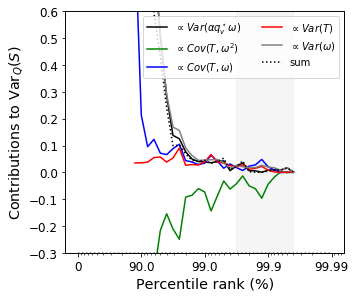

CPU times: user 1.4 s, sys: 28.9 ms, total: 1.42 s
Wall time: 1.43 s


In [168]:
%%time 
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_ylim((-0.3,0.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,Q_IL,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

# subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 all_contribs_var,
                 col=['green','blue','red','grey','k'],ltype=['-','-','-','-',':'],transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to Var$_Q(S)$')
# ax.set_title(r'$S(\omega,T)=\varepsilon\omega_{500}q_v^\star(T)$')

ax.legend([r'$\propto Var(\alpha q_v^\star \omega)$',r'$\propto Cov(T,\omega^2)$',r'$\propto Cov(T,\omega)$',
           r'$\propto Var(T)$',
           r'$\propto Var(\omega)$','sum'],ncol=2,framealpha=0.8)

plt.savefig(os.path.join(figdir,'var_and_contributions_omega_T_%s.pdf'%('-'.join(dates))),
            bbox_inches='tight')

plt.show()